In [1]:
import sys 
#sys.path.append("codes/modules") # add custom Vibe 's modules
#sys.path.append("../..") # add standard 's modules
# sys.path.append('/home/hbkoziel/pyfesom/codes/modules')
sys.path.append('../..') # add standard 's modules
sys.path.append('../modules')

import pyfesom as pf
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.basemap import Basemap
import numpy as np
from netCDF4 import Dataset
import os
import time
import pandas as pd
import xarray as xr

sys.path.append('/home/hbkoziel/pyfesom/pyfesom/cmocean/')
import cmocean as cmap
sys.path.append('/home/hbkoziel/pyfesom/pyfesom/python-gsw/')
import gsw

No joblib
no cmocean


In [2]:
# Loading mesh for run

mesh_id    = 'meshArc4.5'
runid	= 'Arc12'
meshpath   = '/scratch/usr/hbkoziel/mesh/'+mesh_id+'/'            # Defining path where mesh is stored
mesh = pf.load_mesh(meshpath, usepickle=True, get3d=False)        # Loading mesh, stores it in mesh.****  
#mesh = pf.fesom_mesh(meshpath, get3d=True)
#mesh.zlevs = -mesh.zlevs                                            # Depth is made negative
input_directory  = '/scratch/usr/hbkvsk12/hlrn3_work2/results/Arc12/'

/scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh
2
The usepickle == True)
The pickle file for python 2 exists.
The mesh will be loaded from /scratch/usr/hbkoziel/mesh/meshArc4.5/pickle_mesh


In [3]:
ind_all = np.load('index_all.npy')
doy = np.arange(2,352,2)
np.shape(doy)

(175,)

In [4]:
# LOAD BATHY AND FLUXES #

ncfile       = '/scratch/usr/hbkoziel/bathy/ETOPO2v2c_f4.nc'
f           = Dataset(ncfile, 'r')
bathy    = f.variables['z'][:,:]
lonbathy    = f.variables['x'][:]
latbathy    = f.variables['y'][:]
Xbat, Ybat = np.meshgrid(lonbathy,latbathy)

In [5]:
ind = np.max(np.argwhere(mesh.zlevs == 100))
ind_depth = np.array(mesh.n32[:,ind]) # depth max 580m

In [6]:
from derivative import derivative

bafux_2d, bafuy_2d = derivative(mesh)
f0 = 2*7.2921e-5 * np.sin(mesh.y2/180.*np.pi)

Starting derivative calculation
Derivative calculated


In [7]:
year = 2014
ncfile	= input_directory+'/'+runid+'.'+str(year)+'.oce.mean.nc'
f	= Dataset(ncfile,'r')
date = f.variables['time'][:]
np.shape(date)

(175,)

In [8]:
for day in range(40,len(date)):
    ncfile	= input_directory+'/'+runid+'.'+str(year)+'.oce.mean.nc'
    f	= Dataset(ncfile,'r')
    #tracer	= f.variables[tracername][:]
    u	= f.variables['u'][day,ind_depth] - f.variables['u'][day-1,ind_depth]
    v	= f.variables['v'][day,ind_depth] - f.variables['v'][day-1,ind_depth]
    w	= (f.variables['w'][day,ind_depth] - f.variables['w'][day-1,ind_depth]) * 24 * 3600
    t	= f.variables['temp'][day,ind_depth] - f.variables['temp'][day-1,ind_depth]
    s	= f.variables['salt'][day,ind_depth] - f.variables['salt'][day-1,ind_depth]
    p   = np.zeros(np.shape(s))
    ro = gsw.rho(s,t,p) -1000
    (u_rot,v_rot)   = pf.vec_rotate_r2g(50, 15, -90, mesh.x2, mesh.y2, u, v, flag=1)
    rv_elem = np.sum(v_rot[mesh.elem] * bafux_2d,axis=1)-np.sum(u_rot[mesh.elem] * bafuy_2d, axis=1) #over triangle
    RV = np.zeros(len(mesh.x2))*np.nan
    rv_node = np.zeros(len(mesh.x2))
    ind_cnt = np.zeros(len(mesh.x2))
    for ii in range(0,len(mesh.elem)):
        nod_elem=mesh.elem[ii,:]
        rv_node[nod_elem]=rv_node[nod_elem]+rv_elem[ii]
        ind_cnt[nod_elem]=ind_cnt[nod_elem]+1.
    RV = rv_node/ind_cnt/f0
    
    ind = np.max(np.argwhere(mesh.zlevs == 0))
    ind_depth = np.array(mesh.n32[:,ind])
    ncfile	= input_directory+'/'+runid+'.'+str(year)+'.oce.mean.nc'
    f	= Dataset(ncfile,'r')
    chl	= (f.variables['tr06'][day,ind_depth] + f.variables['tr15'][day,ind_depth]) - (f.variables['tr06'][day-1,ind_depth] + f.variables['tr15'][day-1,ind_depth])
    din	= f.variables['tr01'][day,ind_depth] - f.variables['tr01'][day-1,ind_depth]
    
    ncfile	= input_directory+'/'+runid+'.'+str(year)+'.ice.mean.nc'
    f	= Dataset(ncfile,'r')
    ice	= (f.variables['area'][day,:] - f.variables['area'][day-1,:]) *100
    
    # plotting
    fig = plt.figure(figsize=(15, 20), facecolor='w', edgecolor='k')
    
    ax1      = fig.add_subplot(321)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(din))
    data[:] = np.nan
    data[ind_all]=(din[ind_all])
    data, elem_no_nan = pf.get_data(data,mesh,0)
    contours = np.arange(-.6, 0.6, .01)
    #contours = [-1, ]
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'DIN [log10 mmol / m3]'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-0.6,.6,0.2))
    #cbar.ax.set_xticklabels(['0.1','0.2','0.3','.5', '1', '2', '3'])
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.title('Nutrient limitation', fontsize=16)

    ax2      = fig.add_subplot(322)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(chl))
    data[:] = np.nan
    data[ind_all]=(chl[ind_all])
    data, elem_no_nan = pf.get_data(data,mesh,0)
    contours = np.arange(-.2, .21, .01)
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'Chl a [log10 mmol/m3]'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-0.2,.2,0.05))
    #cbar.ax.set_xticklabels(['0.1', '0.2', '0.3', '.5', '1', '2'])
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.title('Nutrient limitation', fontsize=16)

    ax3      = fig.add_subplot(323)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(RV))
    data[:] = np.nan
    data[ind_all]=RV[ind_all]
    data, elem_no_nan = pf.get_data(data,mesh,0)
    contours = np.arange(-.1, .11, .001)
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'relative vorticity normalyzed by f'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-.1, .11, .1))
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)

    ax4      = fig.add_subplot(324)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(w))
    data[:] = np.nan
    data[ind_all]=w[ind_all]
    data, elem_no_nan = pf.get_data(data,mesh,0)
    contours = np.arange(-1, 1.1, .01)
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'W [m/day]'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-1, 1.1, 1))
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.title('Nutrient limitation', fontsize=16)

    ax5      = fig.add_subplot(325)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(ice))
    data[:] = np.nan
    data[ind_all]=ice[ind_all]
    contours = np.arange(-10, 11, .1)
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    data, elem_no_nan = pf.get_data(data,mesh,0)
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'Ice concentration [%]'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-10, 11, 10))
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.title('Nutrient limitation', fontsize=16)

    ax6      = fig.add_subplot(326)
    m = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)
    x, y = m(mesh.x2, mesh.y2)
    data = np.empty(np.shape(ro))
    data[:] = np.nan
    data[ind_all]=ro[ind_all]
    contours = np.arange(-0.2, .2, .01)
    eps=(contours.max()-contours.min())/100.
    data[data<=contours.min()]=contours.min()+eps
    data[data>=contours.max()]=contours.max()-eps
    data, elem_no_nan = pf.get_data(data,mesh,0)
    plabels=[False,False,False,False]
    mlabels=[False,False,False,False]    
    m.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
    m.drawmapboundary(fill_color='0.7')
    m.fillcontinents(color='.5',lake_color='.7')
    im=plt.tricontourf(x, y, elem_no_nan, (data) , levels=contours, cmap=cmap.cm.balance, extend='both')
    label = 'Surface density anomaly [mg/m3]'
    cbar=m.colorbar(im,"bottom", size="5%", pad="2%", ticks = np.arange(-.2, .2, .2))
    cbar.set_label(label, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #plt.title('Nutrient limitation', fontsize=16)
    
    ax1.text(-0.12, 1.05, 'A', transform=ax1.transAxes,
                size=30, weight='bold')
    ax2.text(-0.12, 1.05, 'B', transform=ax2.transAxes,
                size=30, weight='bold')
    ax3.text(-0.12, 1.05, 'C', transform=ax3.transAxes,
                size=30, weight='bold')
    ax4.text(-0.12, 1.05, 'D', transform=ax4.transAxes,
                size=30, weight='bold')
    ax5.text(-0.12, 1.05, 'E', transform=ax5.transAxes,
                size=30, weight='bold')
    ax6.text(-0.12, 1.05, 'F', transform=ax6.transAxes,
                size=30, weight='bold')

    if doy[day] >= 100:
        plt.savefig('/home/hbkoziel/pyfesom/figures/Arc12/snapshots/Laptev_diff/snapshots_'+str(year)+'_'+str(doy[day])+'.png', dpi = 300, bbox_inches='tight') 
    elif doy[day] < 10:
        plt.savefig('/home/hbkoziel/pyfesom/figures/Arc12/snapshots/Laptev_diff/snapshots_'+str(year)+'_00'+str(doy[day])+'.png', dpi = 300, bbox_inches='tight') 
    else:
        plt.savefig('/home/hbkoziel/pyfesom/figures/Arc12/snapshots/Laptev_diff/snapshots_'+str(year)+'_0'+str(doy[day])+'.png', dpi = 300, bbox_inches='tight') 
    plt.close()

For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:120: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in greater_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:143: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:144: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used


/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:167: RuntimeWarning: invalid value encountered in less_equal
/sw/tools/anaconda2/2019.10/skl/lib/python2.7/site-packages/ipykernel_launcher.py:168: RuntimeWarning: invalid value encountered in greater_equal


For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will be used
For depth 0 model level -0.0 will 

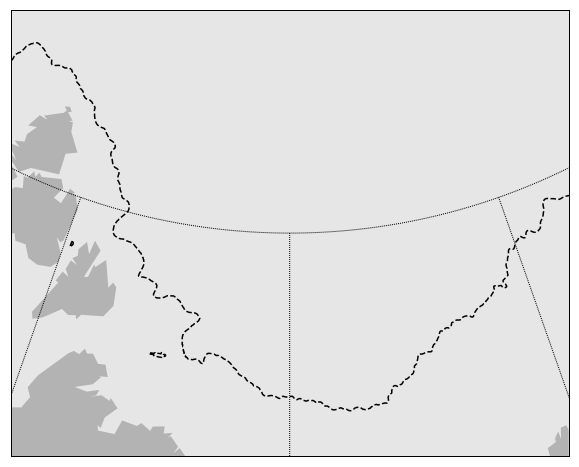

In [9]:
fig = plt.figure(figsize=(10, 15), facecolor='w', edgecolor='k')
#fig.subplots_adjust(wspace=0.02,hspace=0.02)
ax      = fig.add_subplot(111)

map = Basemap(width=1000000,height=800000,resolution='l',projection='aea',\
            lat_1=70.,lat_2=90,lon_0=120,lat_0=80)

#map = Basemap(projection='nplaea',boundinglat=73,lon_0=0,resolution='l')

x, y = map(mesh.x2, mesh.y2)
plabels=[False,False,False,False]
mlabels=[False,False,False,False]    
map.drawparallels(np.arange(-80.,81.,20.), labels=plabels)
map.drawmeridians(np.arange(-180.,181.,20.),labels=mlabels) #[0,1,0,0]
map.drawmapboundary(fill_color='0.9')
map.fillcontinents(color='.7',lake_color='.7')

xxi, yyi = map(Xbat[:],Ybat[:])
ax.contour(xxi,yyi,bathy[:],levels = [-300],colors='k')

In [10]:
np.shape(bathy)

(5400, 10800)